In [55]:
import  pandas as pd
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [57]:
BATCH_SIZE = 2
MAX_LEN = 256
TEST_SAMPLE_SIZE = 7500

In [58]:
dataset_path = "../../data/raw/IMDB Dataset.csv"  

# Load and prepare dataset
def load_imdb_data(path):
    # Modify this function based on your IMDB dataset format
    # Example if using CSV with 'review' and 'sentiment' columns
    df = pd.read_csv(path)
    df.columns = ['sentence', 'value']  # Standardizing column names
    return df

fd = load_imdb_data(dataset_path)

In [59]:
# Add special tokens
sentences = fd['sentence'].astype(str).tolist()

In [60]:
# Tokenization
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

# Encode sentences
encoded = tokenizer(
    sentences,
    add_special_tokens=True,
    max_length=256,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

In [61]:
# Pad sequences
# Extract inputs
input_ids = encoded['input_ids']
attention_mask = encoded['attention_mask']

# Map labels
label_mapping = {'negative': 0, 'positive': 1}
fd['label'] = fd['value'].map(label_mapping)
labels = torch.tensor(fd['label'].values.astype('int64'))

In [62]:
# Split all components
xtrain_ids, xtest_ids, ytrain, ytest = train_test_split(input_ids, labels, test_size=0.15, random_state=42)
xtrain_mask, xtest_mask, _, _ = train_test_split(attention_mask, labels, test_size=0.15, random_state=42)

# Convert to TensorDataset with attention_mask
train_data = TensorDataset(xtrain_ids, xtrain_mask, torch.tensor(ytrain, dtype=torch.long))
test_data = TensorDataset(xtest_ids, xtest_mask, torch.tensor(ytest, dtype=torch.long))

C:\Users\adity\AppData\Local\Temp\ipykernel_8776\3235989527.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data = TensorDataset(xtrain_ids, xtrain_mask, torch.tensor(ytrain, dtype=torch.long))
C:\Users\adity\AppData\Local\Temp\ipykernel_8776\3235989527.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_data = TensorDataset(xtest_ids, xtest_mask, torch.tensor(ytest, dtype=torch.long))


In [63]:
# Load tokenizer and model
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=2)
model.load_state_dict(torch.load("xlnet_imdb_model.pth", map_location=device))

# Ensure model is moved to the same device as the inputs
model = model.to(device)

model.eval()

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\adity\AppData\Local\Temp\ipykernel_8776\3369853446.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode u

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [64]:
# Create the test dataset correctly
test_dataset = TensorDataset(xtest_ids, xtest_mask, ytest)  # xtest_ids is input_ids, xtest_mask is attention_mask
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
all_preds = []
all_labels = []

In [65]:
# Evaluation loop
model.eval()  # Put model in eval mode
with torch.no_grad():
    for batch in test_loader:
        # Ensure all tensors are moved to the same device
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Forward pass with attention_mask
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Or outputs[0] depending on version

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

In [66]:
# Compute evaluation metrics
acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)


In [ ]:
print("\n" + "="*50)
print("XLNet Model Evaluation Metrics (on IMDB)")
print("="*50)
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")


XLNet Model Evaluation Metrics (on IMDB)
Accuracy:  0.9236
F1 Score:  0.9240
Precision: 0.9298
Recall:    0.9182


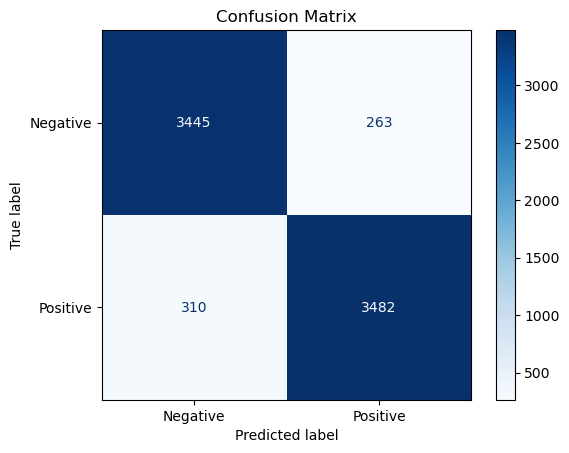

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [71]:
import torch.nn.functional as F

# Label map
label_map = {0: "negative", 1: "positive"}


def predict_sentiment(text, true_label=None):
    """
    Predicts sentiment of a given text using XLNet model.
    Optionally computes metrics if true label is provided.
    """
    # Tokenize
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        confidence, predicted_class = torch.max(probs, dim=1)

    predicted_label = predicted_class.item()
    confidence_score = confidence.item()

    print("\n=====================================")
    print(f"Input Text: {text}")
    print(f"Predicted Label: {label_map[predicted_label]}")
    print(f"Confidence: {confidence_score:.4f}")
    print("=====================================")

    # Optional metrics
    if true_label is not None:
        if isinstance(true_label, str):
            true_label = 1 if true_label.lower() == 'positive' else 0

        accuracy = accuracy_score([true_label], [predicted_label])
        precision = precision_score([true_label], [predicted_label], zero_division=0)
        recall = recall_score([true_label], [predicted_label], zero_division=0)
        f1 = f1_score([true_label], [predicted_label], zero_division=0)

        print("Evaluation Metrics:")
        print(f"Accuracy : {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall   : {recall:.4f}")
        print(f"F1 Score : {f1:.4f}")
        print("=====================================")

    return label_map[predicted_label], confidence_score


In [72]:
predict_sentiment("The movie was very boring and too long.")


Input Text: The movie was very boring and too long.
Predicted Label: negative
Confidence: 0.9959


('negative', 0.9958928823471069)